## In this model I used fast.ai library and the useful tricks that was implemented in this library

In [1]:
!wget -q https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/snake/v0.1/train.zip
!wget -q https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/snake/v0.1/val.zip
!wget -q https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/snake/v0.1/test.zip

In [2]:
!wget -q https://datasets.aicrowd.com/default/aicrowd-practice-challenges/public/snake/v0.1/sample_submission.csv

In [3]:
!mkdir data
!mkdir data/test
!mkdir data/test/venomous
!mkdir data/train
!mkdir data/val

In [4]:
!unzip -q train.zip
!unzip -q test.zip
!unzip -q val.zip

In [5]:
!mv content/data/train/* data/train
!mv content/data/val/* data/val
!mv content/data/test/* data/test/venomous

In [6]:
!rm -rf content/

In [7]:
!mkdir models

In [8]:
import sys
import os
import gc
import warnings
import torch

import torch.nn as nn
import numpy as np
import pandas as pd 
import torch.nn.functional as F

from fastai.script import *
from fastai.vision import *
from fastai.callbacks import *
from fastai.distributed import *
from fastprogress import fastprogress
from torchvision.models import *
from tqdm.notebook import tqdm

In [1]:
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
np.random.seed(23)
torch.cuda.device(0)
warnings.filterwarnings("ignore")
torch.multiprocessing.freeze_support()
print("[INFO] GPU:", torch.cuda.get_device_name())

In [ ]:
def verify_folder(path):
    p = Path(path)
    classes=['venomous','non_venomous']
    for c in classes:
            print(c)
            verify_images(p/c, delete=True)

In [ ]:
!ls data/train

In [ ]:
verify_folder("data/train")
verify_folder("data/val")
# verify images for test
p = Path("data/test")
verify_images(p, delete=True)
# verify_folder("data/test")

In [ ]:
def get_data(size, batch_size, simple=False):
  """
  function that returns a DataBunch as needed for the Learner
  """

  if simple:
    tfms = get_transforms(do_flip = True, flip_vert = True,max_zoom = 1.1)
  else:
    tfms = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, 
                      max_zoom=1.1, max_lighting=0.2, max_warp=0.2, 
                      p_affine=0.75, 
                      p_lighting=0.75)

  src = (ImageList.from_folder("data/train").split_none().label_from_folder())
  src.valid = (ImageList.from_folder("data/val").split_none().label_from_folder()).train
  src = src.transform(tfms, size=size)
  src.test = (ImageList.from_folder("data/test").split_none().label_from_folder()).train
  src.test = src.test.transform(None, size=size)
  data = (src.databunch(num_workers=0, bs=batch_size).normalize(imagenet_stats))    
  print("[INFO] Number of Classes: ", data.c)
  data.num_workers = 4
  return data

[INFO] Number of Classes:  2


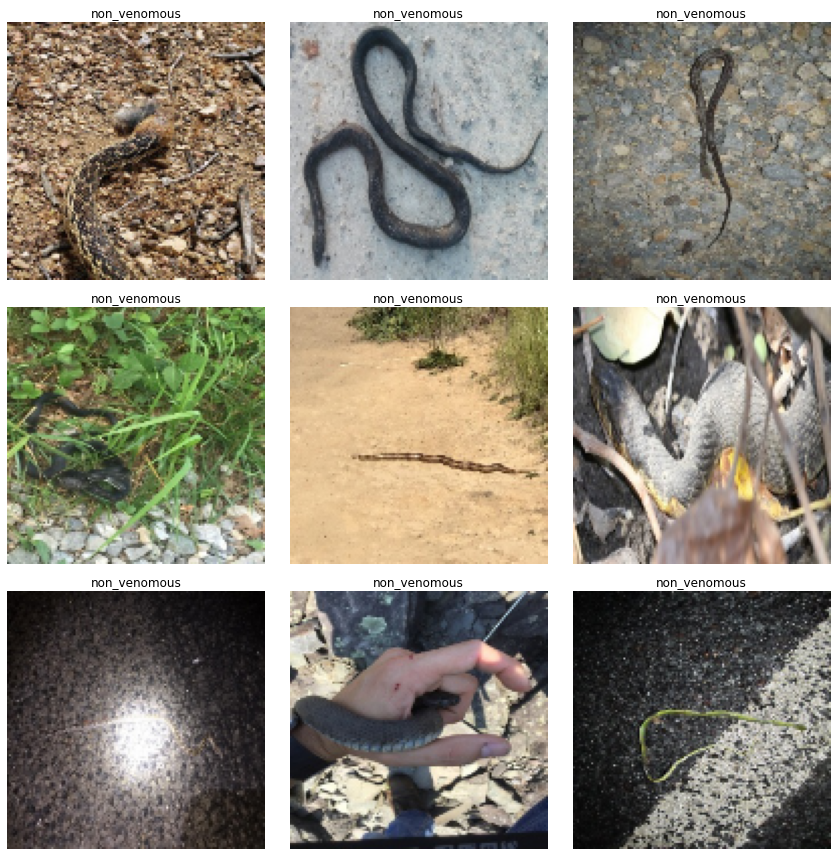

In [ ]:
sample_data = get_data(128, (2048//128))
sample_data.show_batch(3, 3)

In [ ]:
arch = models.densenet161
size = 128
learn = create_cnn(get_data(size, (2048//size), simple=False), arch, pretrained=True, 
                   metrics=[accuracy, FBeta(beta=1,average='macro')])

model_dir = "/content/drive/My Drive/snake/"
model_arch_name = "densenet161_long"
name = model_arch_name

[INFO] Number of Classes:  2


Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


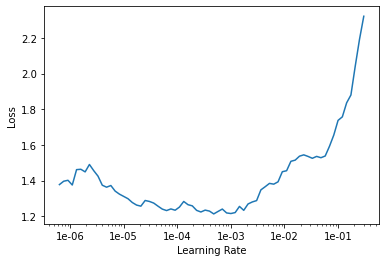

In [ ]:
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.603759,0.565403,0.721300,0.716995,11:51
1,0.546816,0.517125,0.741411,0.738858,11:38
2,0.524248,0.486849,0.755489,0.752175,11:36
3,0.519547,0.464700,0.770739,0.766553,11:38
4,0.489893,0.432241,0.788839,0.782799,11:39
5,0.450172,0.417808,0.798224,0.795416,11:32
6,0.456685,0.407381,0.805430,0.801941,11:35
7,0.450022,0.409296,0.806100,0.804535,11:33


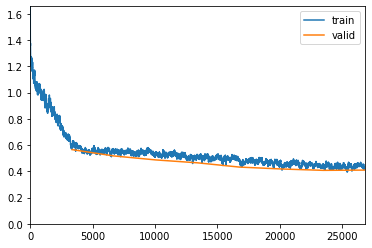

Better model found at epoch 0 with f_beta value: 0.7169948816299438.
Better model found at epoch 1 with f_beta value: 0.7388579845428467.
Better model found at epoch 2 with f_beta value: 0.7521746754646301.
Better model found at epoch 3 with f_beta value: 0.7665534019470215.
Better model found at epoch 4 with f_beta value: 0.7827991843223572.
Better model found at epoch 5 with f_beta value: 0.7954161167144775.
Better model found at epoch 6 with f_beta value: 0.8019406199455261.
Better model found at epoch 7 with f_beta value: 0.8045346736907959.


In [ ]:
learn.fit_one_cycle(8, 1e-3, callbacks=[ShowGraph(learn),
                            SaveModelCallback(learn, monitor='f_beta', mode='max', name=name)])

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


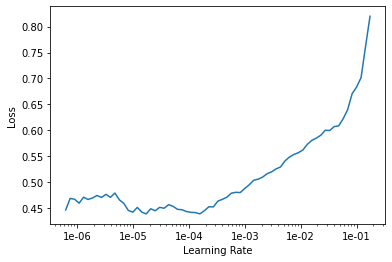

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.440080,0.427639,0.793699,0.790702,13:18
1,0.496623,0.440046,0.795039,0.790692,13:37
2,0.464716,0.428339,0.801575,0.797050,13:35
3,0.444634,0.408476,0.801575,0.796797,13:31
4,0.444207,0.394555,0.813139,0.807695,13:26


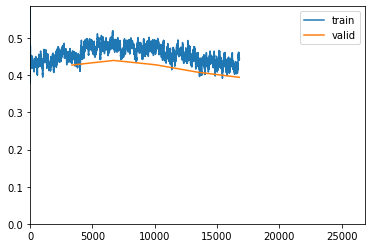

Better model found at epoch 0 with f_beta value: 0.7907019257545471.
Better model found at epoch 2 with f_beta value: 0.7970502376556396.
Better model found at epoch 4 with f_beta value: 0.8076945543289185.
Buffered data was truncated after reaching the output size limit.

In [ ]:
learn.fit_one_cycle(8, slice(1e-4/3, 1e-4) , callbacks=[ShowGraph(learn),
                            SaveModelCallback(learn, monitor='f_beta', mode='max', name=name)])

In [ ]:
learn.model_dir = model_dir
learn.save(f'{model_arch_name}_stage-1')

[INFO] Number of Classes:  2


epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


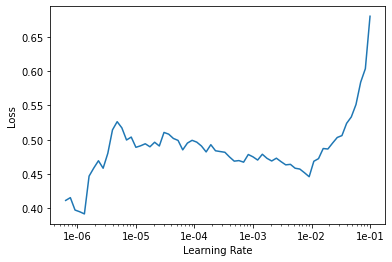

In [ ]:
size = 224
learn.data = get_data(size, (2048//size), simple=False)
learn.freeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.410969,0.341592,0.850846,0.847222,19:48
1,0.434338,0.376962,0.829060,0.826923,19:24
2,0.452515,0.384880,0.819340,0.816870,19:07


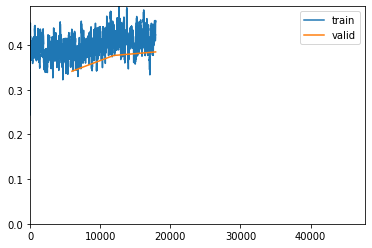

Better model found at epoch 0 with f_beta value: 0.8472224473953247.
Buffered data was truncated after reaching the output size limit.

In [ ]:
learn.fit_one_cycle(8, 1e-3, callbacks=[ShowGraph(learn),
                            SaveModelCallback(learn, monitor='f_beta', mode='max', name=name)])

epoch,train_loss,valid_loss,accuracy,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


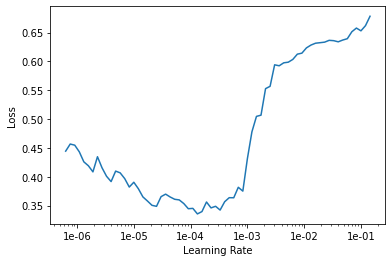

In [ ]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.305829,0.309059,0.860734,0.858791,21:38
1,0.346822,0.322470,0.855539,0.852060,21:56
2,0.362594,0.355800,0.841294,0.834441,22:18


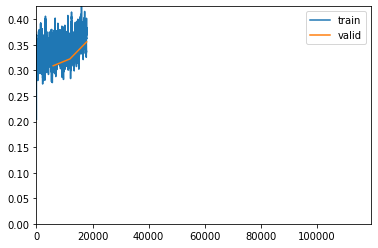

Better model found at epoch 0 with f_beta value: 0.8587906360626221.
Buffered data was truncated after reaching the output size limit.

In [ ]:
learn.fit_one_cycle(20, slice(1e-4/3, 1e-4) , callbacks=[ShowGraph(learn),
                            SaveModelCallback(learn, monitor='f_beta', mode='max', name=name)])

In [ ]:
learn.save(f'{model_arch_name}_stage-2')

[INFO] Number of Classes:  2


None

None

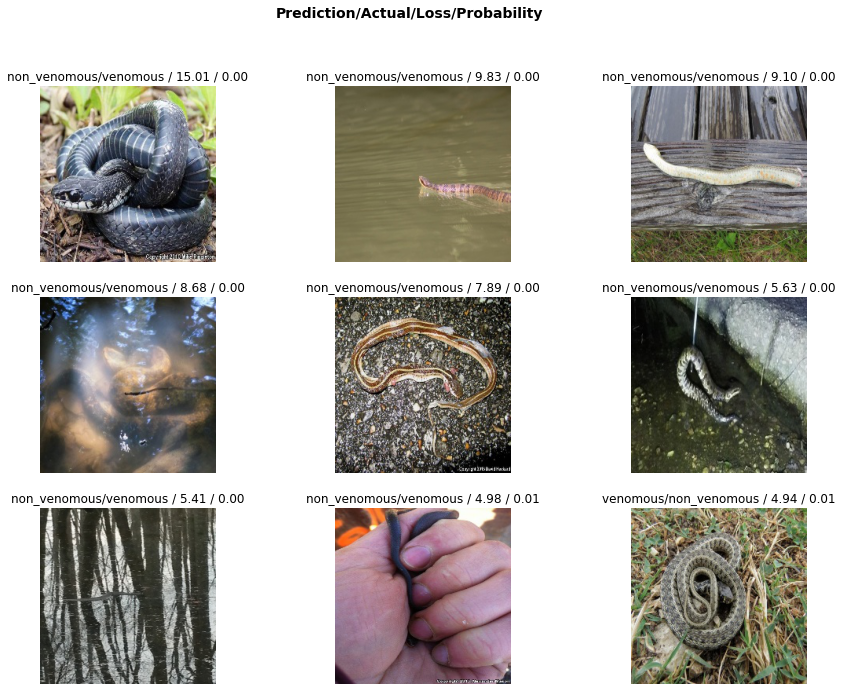

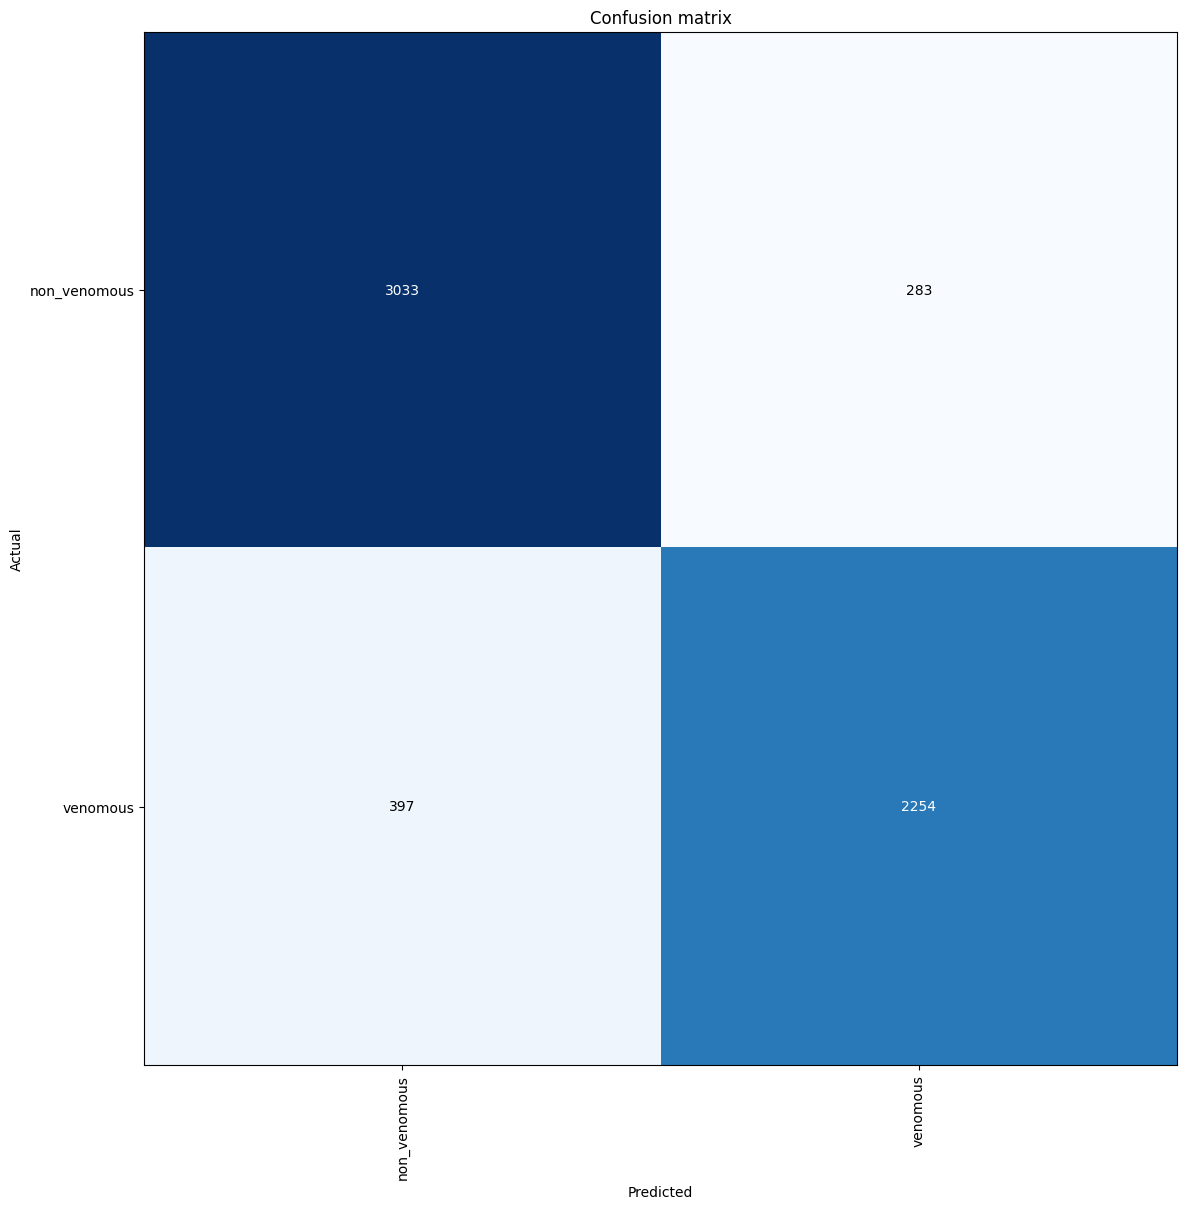

In [ ]:
size = 224
learn = create_cnn(get_data(size, (2048//size)), models.densenet161, 
                     metrics=[accuracy, 
                              FBeta(beta=1,average='macro')])
learn.model_dir = model_dir
learn.load(f'{model_arch_name}_stage-2')
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()

display(interp.plot_top_losses(9, figsize=(15,11)))
display(interp.plot_confusion_matrix(figsize=(12,12), dpi=100))

In [ ]:
print("[INFO] MOST CONFUSED:")
interp.most_confused(min_val=5)

[INFO] MOST CONFUSED:


[('venomous', 'non_venomous', 397), ('non_venomous', 'venomous', 283)]

In [ ]:
def generateSubmission(learner):
    submissions = pd.read_csv('sample_submission.csv')
    id_list = list(submissions.id)
    preds,y = learner.TTA(ds_type=DatasetType.Test)
    pred_list = list(preds[:,1])
    pred_dict = dict((key, value.item()) for (key, value) in zip(learner.data.test_ds.items,pred_list))
    pred_ordered = [pred_dict[Path('data/test/venomous/' + id + '.jpg')] for id in id_list]
    dct = learn.data.c2i
    rev_subs = { v:k for k,v in dct.items()}
    pred_ordered = [rev_subs.get(int(round(float(item))), item)  for item in pred_ordered]
    submissions = pd.DataFrame({'id':id_list,'class':pred_ordered})
    submissions.to_csv(model_dir+"submission_densenet161_long_tta.csv",index = False)

In [ ]:
generateSubmission(learn)